In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extreme Gradient Boost


In [16]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"



In [42]:
import pandas as pd
df_enriched_features=pd.read_feather(file_enriched_features)
df_weather_data = pd.read_feather(file_weather_data)
df_solar_data = pd.read_feather(file_solar_data)


# use list comprehension to get list of columns for level 1 and level 2 from weather data
level1_features = [level for level in df_weather_data.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_weather_data.columns.tolist() if level.startswith('level2_')]

In [43]:
# Show the columns/features and data types for each dataset using pandas DataFrame
import seaborn as sns
sns.set_theme()
feature_columns = {
    "Enriched Features": df_enriched_features.columns,
    "Weather Data": df_weather_data.columns,
    "Solar Data": df_solar_data.columns,
}
for title, cols in feature_columns.items():
    print(f"\n{title} Columns and Data Types:")
    display(pd.DataFrame({"Columns": cols, "Data Types": eval(f"df_{title.lower().replace(' ', '_')}").dtypes}))


Enriched Features Columns and Data Types:


,Columns,Data Types
DateTime,DateTime,datetime64[ns]
# Observation period,# Observation period,object
TOA,TOA,float64
Clear sky GHI,Clear sky GHI,float64
Clear sky BHI,Clear sky BHI,float64
Clear sky DHI,Clear sky DHI,float64
Clear sky BNI,Clear sky BNI,float64
GHI,GHI,float64
BHI,BHI,float64
DHI,DHI,float64



Weather Data Columns and Data Types:


,Columns,Data Types
DateTime,DateTime,datetime64[ns]
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
Sunshine Duration,Sunshine Duration,Float64
Condition Code,Condition Code,Float64
Precipitation(mm),Precipitation(mm),Float64
Dew Point(C),Dew Point(C),Float64
Wind Direction(deg),Wind Direction(deg),Float64
Wind Speed(m/s),Wind Speed(m/s),Float64
Wind Gust(m/s),Wind Gust(m/s),Float64



Solar Data Columns and Data Types:


,Columns,Data Types
Date,Date,object
Number,Number,int64
Time,Time,object
Working State,Working State,object
PV(W),PV(W),float64
Battery(W),Battery(W),float64
Grid(W),Grid(W),float64
Load(W),Load(W),float64
SOC(%),SOC(%),float64
Total_Yield(kWh),Total_Yield(kWh),float64


In [20]:
# merge all the 3 dataframes on DateTime
df_merge = df_solar_data.merge(right=df_weather_data,how='inner',left_on='DateTime',right_on='DateTime')
df_merge = df_merge.merge(right=df_enriched_features,how='inner',left_on='DateTime',right_on='DateTime')
# convert DateTime to datetime
df_merge['DateTime'] = pd.to_datetime(df_merge['DateTime'])
df_merge['Month_Sin'] = np.sin(2 * np.pi * (df_merge['DateTime'].dt.month - 1) / 12)
df_merge['DayOfYear_Sin'] = np.sin(2 * np.pi * (df_merge['DateTime'].dt.dayofyear - 1) / 365)
df_merge['HourOfDay_Sin'] = np.sin(2 * np.pi * (df_merge['DateTime'].dt.hour) / 24)
print(f"df_merge  {df_merge.columns.to_list()}")
print(f"df_merge  {df_merge.shape}")

df_merge  ['Date_x', 'Number', 'Time_x', 'Working State', 'PV(W)', 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)', 'Source_File', 'DateTime', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time_y', 'Date_y', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']

In [44]:
# change all the 3  to an hourly aggregation using resample
print(df_enriched_features.columns.to_list())
df_solar_per_hour = df_solar_data[['PV(W)','DateTime']].resample('h', on='DateTime').agg('mean')
# weather is now hourly so just copy
df_weather_per_hour = df_weather_data.copy()
# 'DateTime', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)'
df_enriched_per_hour = df_enriched_features.copy()

['DateTime', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)']


In [46]:
import numpy as np
# Merge the three dataframes on DateTime
df_merge_hourly = df_solar_per_hour.merge(df_weather_per_hour, on='DateTime').merge(df_enriched_per_hour, on='DateTime')
df_merge_hourly.reset_index(inplace=True)
# Add WeekOfYear
df_merge_hourly['WeekOfYear'] = df_merge_hourly['DateTime'].dt.isocalendar().week
df_merge_hourly['Month_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.month - 1) / 12)
df_merge_hourly['DayOfYear_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.dayofyear - 1) / 365)
df_merge_hourly['HourOfDay_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.hour) / 24)
# Count number Nan in target Y column
print("Number of NaN in PV(W):", df_merge_hourly['PV(W)'].isna().sum())
# Remove Nan in target Y column
df_merge_hourly = df_merge_hourly.dropna(subset=['PV(W)'])
# Count number of rows after removing NaN
print("Number of NaN  after removing in PV(W):", df_merge_hourly['PV(W)'].isna().sum())
print("Number of rows after removing NaN in PV(W):", len(df_merge_hourly))
print("Dataframe shape after removing NaN in PV(W):", df_merge_hourly.shape)

Number of NaN in PV(W): 413
Number of NaN  after removing in PV(W): 0
Number of rows after removing NaN in PV(W): 9981
Dataframe shape after removing NaN in PV(W): (9981, 61)


In [50]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_merge_hourly.columns, "Data Types": df_merge_hourly.dtypes}))


,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Total_Power_ClearSky_Output(W),Total_Power_ClearSky_Output(W),float64
WeekOfYear,WeekOfYear,UInt32
Month_Sin,Month_Sin,float64
DayOfYear_Sin,DayOfYear_Sin,float64


In [51]:
print("Columns:", df_merge_hourly.columns.tolist())#
#feature_cols = ['Temperature(C)', 'Humidity(%)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin',
#                'Total_Power_ClearSky_Output(W)','Power_ClearSky_Pane_I(W)','Power_ClearSky_Pane_II(W)']
feature_cols = ['Temperature(C)', 'Humidity(%)', 'Month_Sin',  'HourOfDay_Sin', 
                'Total_Power_ClearSky_Output(W)']
feature_cols.extend(level1_features)
target_col = 'PV(W)'
print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")
# first we filter  out where the output is less than threshold - to avoid night time data , this is based on clearsky GHI
df_daytime = df_merge_hourly['Clear sky GHI'] > 10
# now split into test and training based test and train data sets are every other week
df_daytime_train = df_merge_hourly[(df_merge_hourly['WeekOfYear'] % 2 == 0) & (df_daytime)]
df_daytime_test = df_merge_hourly[(df_merge_hourly['WeekOfYear'] % 2 == 1) & (df_daytime)]
print("Training DataFrame shape:", df_daytime_train.shape)
print("Testing DataFrame shape:", df_daytime_test.shape)
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]


Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky

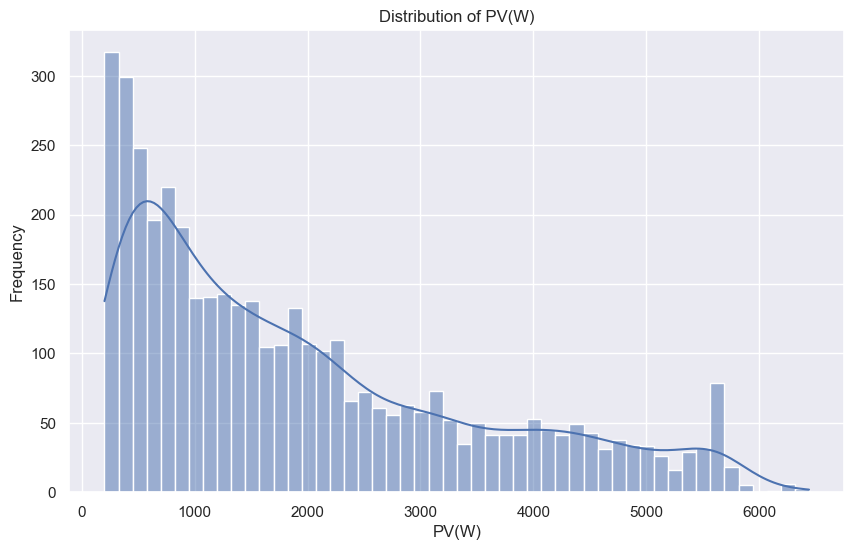

In [52]:
# plot a histogram of the target variable PV(W)
plt.figure(figsize=(10,6))
sns.histplot(df_merge['PV(W)'][df_merge['PV(W)']>200], bins=50, kde=True)
plt.title('Distribution of PV(W)')
plt.xlabel('PV(W)')
plt.ylabel('Frequency')
plt.show()

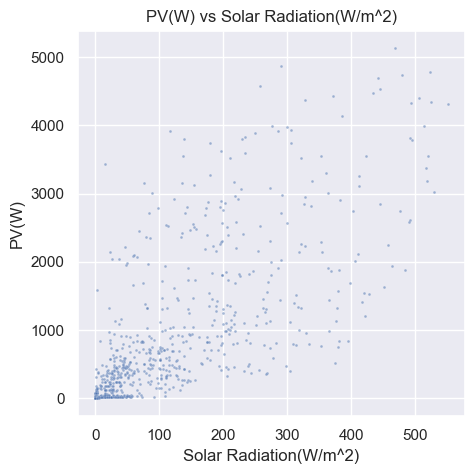

In [53]:
# create a scatter plot of PV(W) vs Solar Radiation(W/m^2)
from datetime import date
plt.figure(figsize=(5,5))
# filter the date range for the scatter plot to be between 2025-01-01 and 2025-01-31 using date type comparison
start_date = date(2025, 1, 1)
end_date = date(2025, 3, 15)
# convert string to date type



sns.scatterplot(x='GHI', y='PV(W)', data=df_merge[(df_merge['Date_y'] >= start_date) & (df_merge['Date_y'] <= end_date)], alpha=0.5, s=4)
plt.title('PV(W) vs Solar Radiation(W/m^2)')
plt.xlabel('Solar Radiation(W/m^2)')
#sns.scatterplot(x='GHI', y='PV(W)', data=df_merge[(df_merge['Date_y'] >= date(2025, 3,14)) & (df_merge['Date_y'] <= date(2025, 8,20))], alpha=0.5, s=4)
#plt.title('PV(W) vs Solar Radiation(W/m^2)')
#plt.xlabel('Solar Radiation(W/m^2)')
#plt.ylabel('PV(W)')
plt.ylabel('PV(W)')
plt.show()

In [54]:
#df_merge  ['Date_x', 'Number', 'Time_x', 'Working State', 'PV(W)', 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)', 'Source_File', 'DateTime', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time_y', 'Date_y', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
#df_merge  (9832, 59)
print("Definining Features")
# 1. Define Features (X) and Target (y)
# Dropping 'DateTime' as XGBoost needs numerical inputs, and 'PV(W)' because it's the target
features = ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 
            'Condition Code',  'DayOfYear_Sin', 'HourOfDay_Sin', 'Clear sky GHI']
target = 'PV(W)'
#print("Definining x and y")
X = df_merge[features][df_merge['Clear sky GHI']>10]
y = df_merge[target][df_merge['Clear sky GHI']>10]
print("Splitting")
# 2. Split into Train and Test sets (80% Train, 20% Test)
# random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Definining Features
Splitting
Training samples: 3875
Testing samples: 969


In [55]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [56]:
# 2. Initialize the Base Learner
# For regression, we often use a slightly deeper tree than a "stump"
base_tree = DecisionTreeRegressor(max_depth=8, random_state=42)
#Parameter,Recommended Setting,Reason
#estimator,DecisionTreeRegressor(max_depth=4) to 8,"Unlike simple classification, solar data needs slightly deeper trees (not just stumps) to capture interactions between humidity, temperature, and sun angle."
#n_estimators,100 to 500,Solar data is complex; you usually need more than the default 50 trees to reach a stable error rate.
#learning_rate,0.05 to 0.1,"A lower learning rate prevents the model from ""over-correcting"" for a single stormy day (outlier) in your training set."
#loss,'square' or 'linear',"'square' is effective if you want to penalize large forecasting misses heavily, which is critical for grid stability."
# 3. Initialize and train AdaBoost
# 'loss' can be 'linear', 'square', or 'exponential'
ada_regr = AdaBoostRegressor(
    estimator=base_tree,
    n_estimators=1000,
    learning_rate=0.05,
    loss='linear',
    random_state=42
)

ada_regr.fit(X_train, y_train)

# 4. Predict and Evaluate
y_pred = ada_regr.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The average prediction error (RMSE) is: {rmse:.4f}")
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE):  {mae:.2f}")
# And norrmalized RMSE and MAE based on 8400 W peak
nrmse = rmse / 8400
nmae = mae / 8400
print(f"Normalized RMSE: {nrmse:.4f}")
print(f"Normalized MAE: {nmae:.4f}")
# As a percentage
print(f"NRMSE (%): {nrmse * 100:.2f}%")
print(f"NMAE (%): {nmae * 100:.2f}%")

R2 Score: 0.707
MSE: 732711.839
The average prediction error (RMSE) is: 855.9859
Mean Absolute Error (MAE):  632.39
Normalized RMSE: 0.1019
Normalized MAE: 0.0753
NRMSE (%): 10.19%
NMAE (%): 7.53%


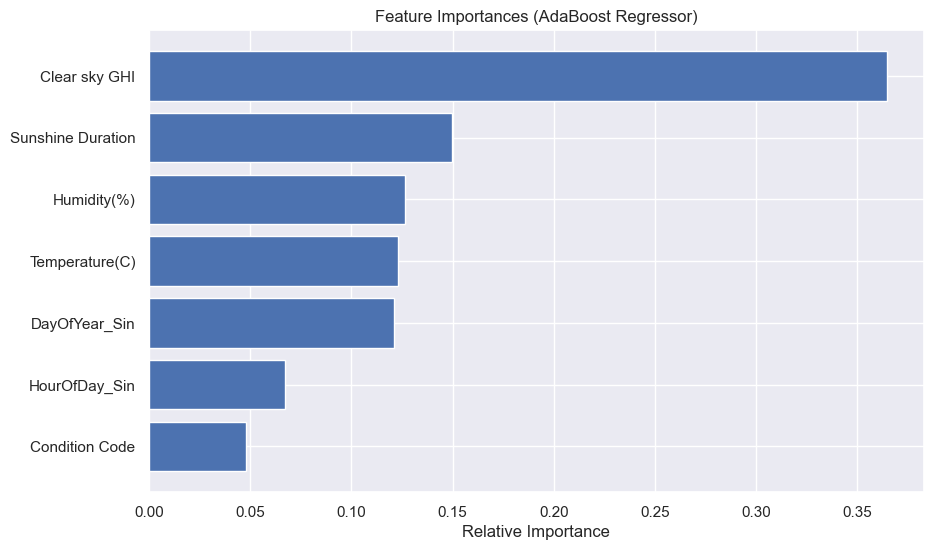

In [57]:
import matplotlib.pyplot as plt

# Get feature importances
importances = ada_regr.feature_importances_
features = features

# Sort and Plot
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (AdaBoost Regressor)")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

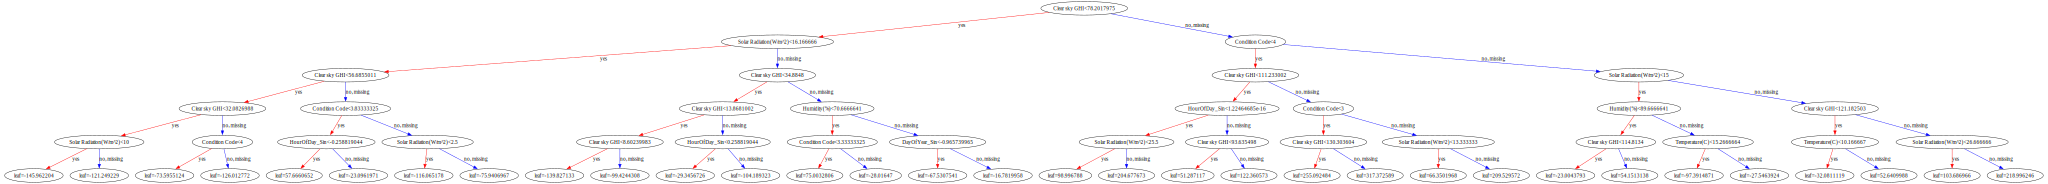

In [ ]:
try:
    import graphviz
except: 
    %pip install graphviz
    import graphviz

#xgb.plot_tree(xg_reg)
xgb.to_graphviz(xg_reg)

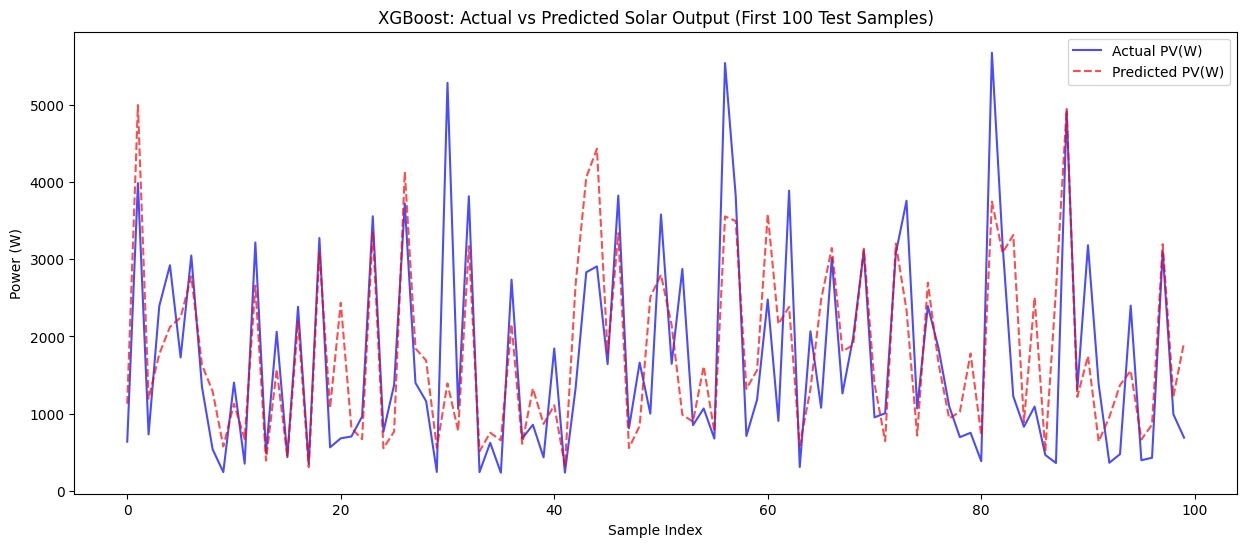

<Figure size 1000x600 with 0 Axes>

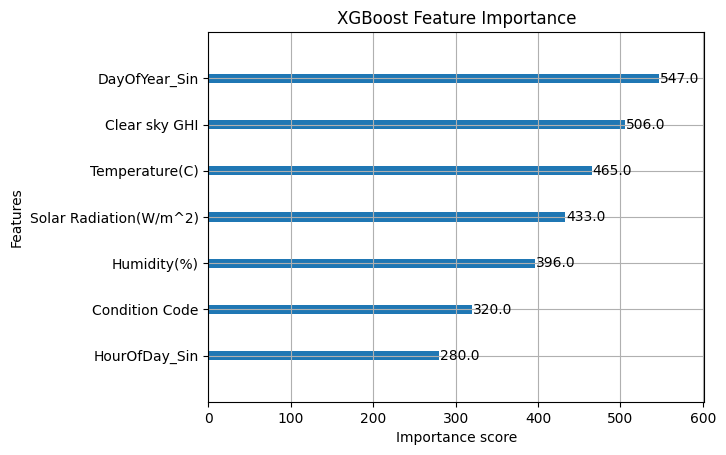

In [ ]:


# 7. Visualize Actual vs Predicted (First 100 test points for clarity)
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual PV(W)', color='blue', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted PV(W)', color='red', linestyle='--', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted Solar Output (First 100 Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

# 8. Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(xg_reg, max_num_features=10)
plt.title('XGBoost Feature Importance')
plt.show()

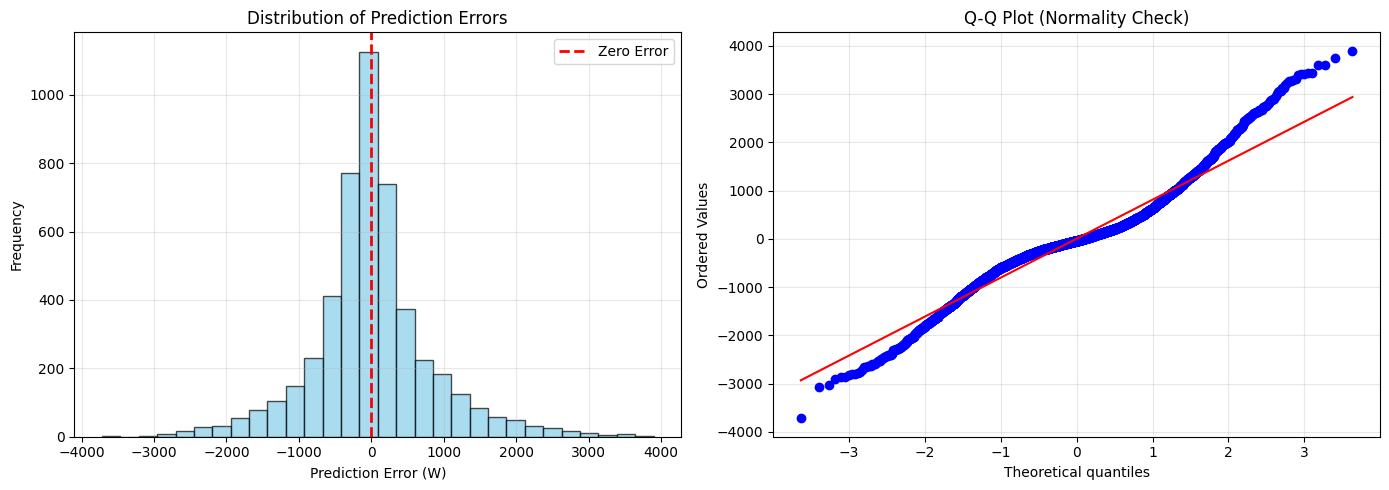

Error Mean: 3.57 W
Error Std Dev: 829.17 W
Error Min: -3719.09 W
Error Max: 3897.91 W


In [ ]:
# plot error distribution
# plot error distribution
errors = y_test.values - y_pred

plt.figure(figsize=(14, 5))

# Histogram of errors
plt.subplot(1, 2, 1)
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Prediction Error (W)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.grid(alpha=0.3)

# Q-Q plot for normality check
plt.subplot(1, 2, 2)
from scipy import stats
stats.probplot(errors, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print error statistics
print(f"Error Mean: {errors.mean():.2f} W")
print(f"Error Std Dev: {errors.std():.2f} W")
print(f"Error Min: {errors.min():.2f} W")
print(f"Error Max: {errors.max():.2f} W")